# Waveguide Bragg Grating

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import gdsfactory as gf
import meep as mp
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs
import gplugins.modes as gmode
import pandas as pd

Using MPI version 4.1, 1 processes
2025-10-14 18:14:51.010 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


## Waveguide Bragg grating from GDS Factory

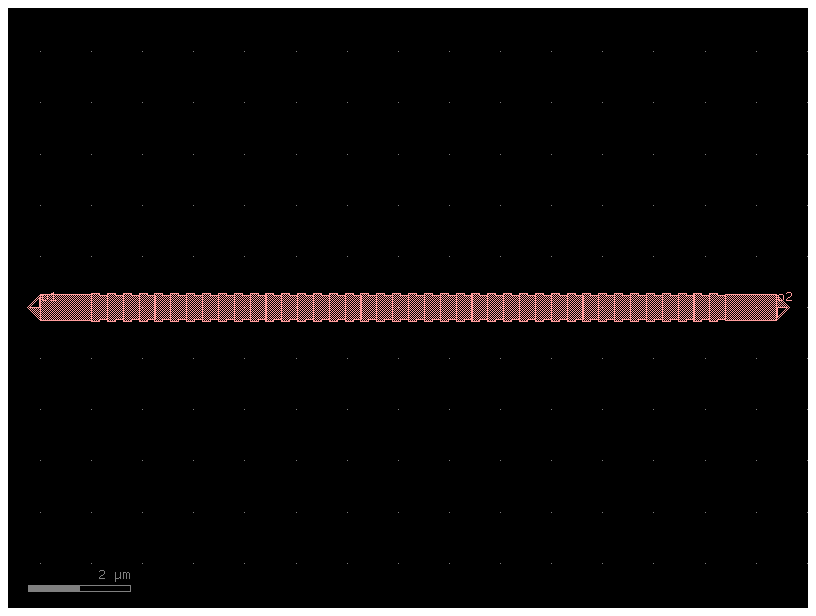

In [74]:
wg_width = 0.5
delta_width=0.050
period = 0.310
length = period/2
NG=40
dbr = gf.components.dbr(
    w1=wg_width+delta_width,
    w2=wg_width-delta_width,
    l1=length,
    l2=length,
    n=40,
    straight_length=1).copy()
dbr.add_port(name='o2', center=(dbr.xmax, 0), width=wg_width, orientation=0,layer=(1,0))
dbr.draw_ports()
dbr.plot()

Phase shift DBR

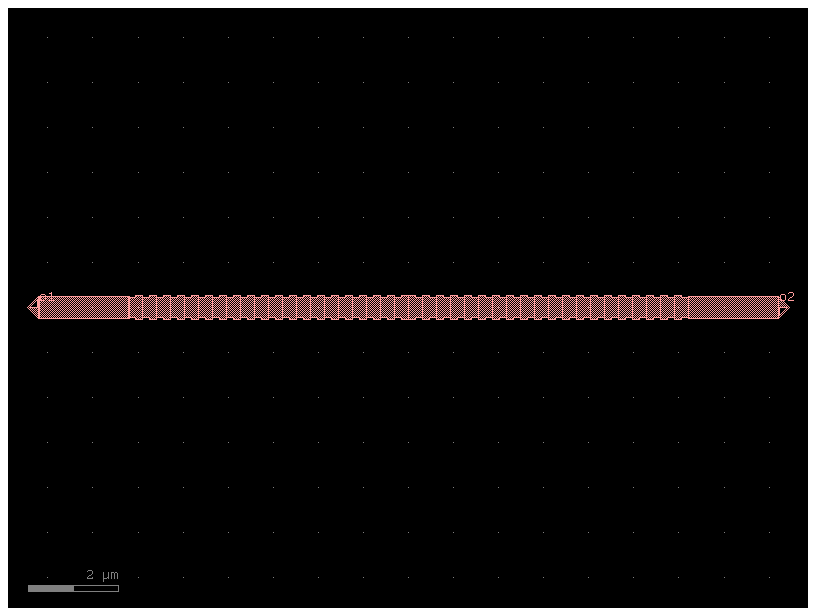

In [10]:
@gf.cell
def phase_shift_dbr(period = 0.310, n_period = 40, width1 = 0.55, width2 = 0.45):
    # Create the two-segment unit cell of the DBR
    length=period/2
    dbr1 = gf.components.dbr(w1=width2,w2=width1,l1=length,l2=length,n=n_period/2,straight_length=0).copy()
    dbr1.add_port(name='o2', center=(dbr1.xmax, 0), width=width1, orientation=0,layer=(1,0))
    dbr2 = gf.components.dbr(w1=width1,w2=width2,l1=length,l2=length,n=n_period/2,straight_length=0).copy()
    dbr2.add_port(name='o2', center=(dbr2.xmax, 0), width=width1, orientation=0,layer=(1,0))
    straight = gf.components.straight(length=2, width=0.5)

    phase_dbr = gf.Component()
    dbr1_ref = phase_dbr.add_ref(dbr1)
    dbr2_ref = phase_dbr.add_ref(dbr2)
    straight1_ref = phase_dbr.add_ref(straight)
    straight2_ref = phase_dbr.add_ref(straight)
    dbr1_ref.connect("o2", dbr2_ref.ports["o1"], allow_width_mismatch=True) 
    straight1_ref.connect("o1", dbr2_ref.ports["o2"], allow_width_mismatch=True)
    straight2_ref.connect("o2", dbr1_ref.ports["o1"], allow_width_mismatch=True)

    return phase_dbr   

gf.clear_cache()
pi_dbr = phase_shift_dbr().copy()
pi_dbr.add_port(name='o2', center=(pi_dbr.xmax, 0), width=0.5, orientation=0,layer=(1,0))
pi_dbr.add_port(name='o1', center=(pi_dbr.xmin, 0), width=0.5, orientation=180,layer=(1,0))
pi_dbr.draw_ports()
pi_dbr.plot()


# Mode calculation

Get the effective index vs wavelength and width using mode calculation

In [8]:
help(gmode.find_neff_vs_width)

Help on function find_neff_vs_width in module gplugins.modes.find_neff_vs_width:

find_neff_vs_width(
    width1: 'float' = 0.2,
    width2: 'float' = 1.0,
    steps: 'int' = 12,
    nmodes: 'int' = 4,
    wavelength: 'float' = 1.55,
    parity=0,
    filepath: 'PathType | None' = None,
    overwrite: 'bool' = False,
    **kwargs
) -> 'pd.DataFrame'
    Sweep waveguide width and compute effective index.

    Args:
        width1: starting waveguide width in um.
        width2: end waveguide width in um.
        steps: number of points.
        nmodes: number of modes to compute.
        wavelength: wavelength in um.
        parity: mp.ODD_Y mp.EVEN_X for TE, mp.EVEN_Y for TM.
        filepath: Optional filepath to store the results.
        overwrite: overwrite file even if exists on disk.


    Keyword Args:
        slab_thickness: thickness for the waveguide slab in um.
        core_material: core material refractive index.
        clad_material: clad material refractive index.
     

In [4]:
help(gmode.find_modes)

Help on module gplugins.modes.find_modes in gplugins.modes:

NAME
    gplugins.modes.find_modes - Compute modes of a rectangular Si strip waveguide on top of oxide. Note that you should only pay attention, here, to the guided modes, which are the modes whose frequency falls under the light line -- that is, frequency < beta / 1.45, where 1.45 is the SiO2 index.

DESCRIPTION
    Since there's no special lengthscale here, you can just
    use microns. In general, if you use units of x, the frequencies
    output are equivalent to x/lambda# so here, the frequencies will be
    output as um/lambda, e.g. 1.5um would correspond to the frequency
    1/1.5 = 0.6667.

FUNCTIONS
    find_modes_waveguide(
        tol: float = 1e-06,
        wavelength: float = 1.55,
        mode_number: int = 1,
        parity=0,
        cache_path: str | pathlib._local.Path | None = PosixPath('/home/ramprakash/.gdsfactory/modes'),
        overwrite: bool = False,
        single_waveguide: bool = True,
        **k

In [ ]:
# using gmode based on MPB for width sweep and lamda sweep 
mp.verbosity(0)

wavelengths = np.linspace(1.5, 1.6, 10)
# Initialize lists to store results
all_wavelengths = []
all_widths = []
all_neffs = []
for wavelength in wavelengths:
    mode_width = gmode.find_neff_vs_width(width1=0.3,
                                    width2=0.7,
                                    steps=10,
                                    nmodes=1,
                                    wavelength=wavelength,
                                    resolution=20,
                                    sy=6,
                                    sz=6,
                                    core_material=3.45,
                                    clad_material=1.45)

    # Store results
    for _, row in mode_width.iterrows():
        all_wavelengths.append(wavelength)
        all_widths.append(row['width'])
        all_neffs.append(row[1])

df_results = pd.DataFrame({
    'wavelength': all_wavelengths,
    'width': all_widths,
    'neff': all_neffs
})

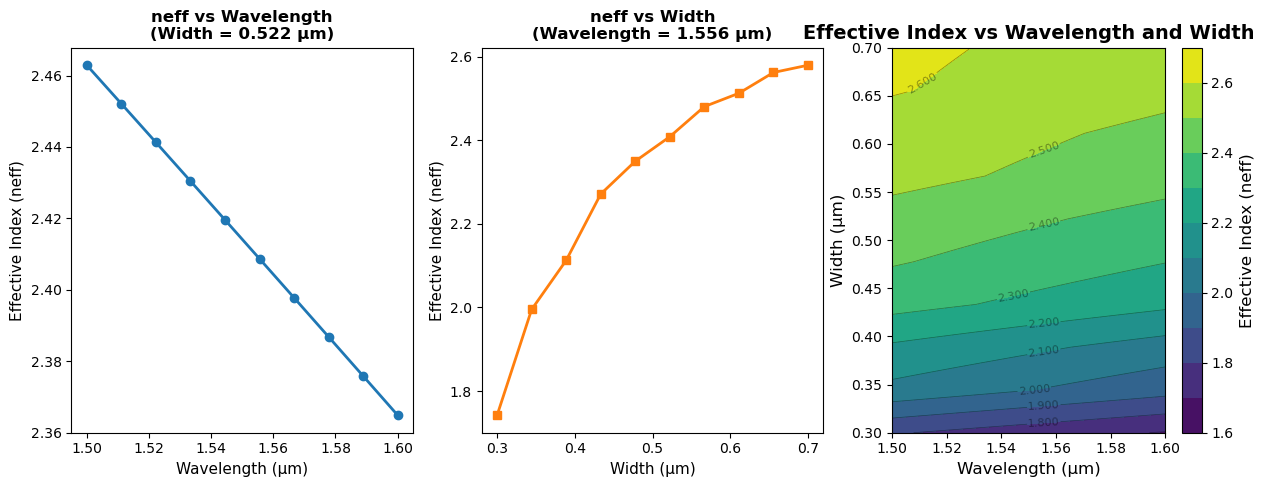

In [41]:
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
unique_widths = sorted(df_results['width'].unique())
fixed_width = unique_widths[len(unique_widths)//2]
data = df_results[df_results['width'] == fixed_width]
ax1.plot(data['wavelength'], data['neff'], marker='o', 
         color='tab:blue', linewidth=2, markersize=6)
ax1.set_xlabel('Wavelength (µm)', fontsize=11)
ax1.set_ylabel('Effective Index (neff)', fontsize=11)
ax1.set_title(f'neff vs Wavelength\n(Width = {fixed_width:.3f} µm)', 
              fontsize=12, fontweight='bold')

ax2 = plt.subplot(1, 3, 2)
unique_wavelengths = sorted(df_results['wavelength'].unique())
fixed_wavelength = unique_wavelengths[len(unique_wavelengths)//2]
data = df_results[df_results['wavelength'] == fixed_wavelength]
ax2.plot(data['width'], data['neff'], marker='s', 
         color='tab:orange', linewidth=2, markersize=6)
ax2.set_xlabel('Width (µm)', fontsize=11)
ax2.set_ylabel('Effective Index (neff)', fontsize=11)
ax2.set_title(f'neff vs Width\n(Wavelength = {fixed_wavelength:.3f} µm)', 
              fontsize=12, fontweight='bold')

ax3 = plt.subplot(1, 3, 3)
pivot_data = df_results.pivot(index='width', columns='wavelength', values='neff')

levels = 10  # Number of contour levels
contourf = ax3.contourf(pivot_data.columns, pivot_data.index, pivot_data.values, 
                       levels=levels, cmap='viridis')

contour = ax3.contour(pivot_data.columns, pivot_data.index, pivot_data.values, 
                     levels=levels, colors='black', linewidths=0.5, alpha=0.4)

ax3.clabel(contour, inline=True, fontsize=8, fmt='%.3f')

cbar = plt.colorbar(contourf, ax=ax3)
cbar.set_label('Effective Index (neff)', fontsize=12)

ax3.set_xlabel('Wavelength (µm)', fontsize=12)
ax3.set_ylabel('Width (µm)', fontsize=12)
ax3.set_title('Effective Index vs Wavelength and Width', fontsize=14, fontweight='bold')

df_results.to_csv('WG_neff_lam_width.csv', index=False)

Using the curve fitted functions for effective index

$n_{neff-\lambda}(\lambda) = a_0-a_1(\lambda-\lambda_0)-a_2(\lambda-\lambda_0)^2$

$\Delta n_{neff-w}(w) = b_1(w-w_0)+b_2(w-w_0)^2-b_3(w-w_0)^3$

$n_{eff}(\lambda,w)=n_{eff-\lambda}(\lambda)+\Delta n_{neff-w}(w)$

The fit function is from book `Silicon Photonics Design by Lukas Chrostowski and Michael Hochberg`.


In [3]:
# Coded with help of Claude.ai
df_results = pd.read_csv('WG_neff_lam_width.csv')
from scipy.optimize import curve_fit

lam0 = df_results['wavelength'].median()
w0 = df_results['width'].median()

print(f"\nReference points:")
print(f"  λ₀ = {lam0:.4f} µm")
print(f"  w₀ = {w0:.4f} µm")

# ============================================
# Step 2: Fit neff vs wavelength at reference width w0
# ============================================
print(f"\n{'='*60}")
print("STEP 1: Fitting neff(λ) at reference width w₀")
print("="*60)

# Get data at reference width (or closest width)
unique_widths = sorted(df_results['width'].unique())
w0_actual = min(unique_widths, key=lambda x: abs(x - w0))
data_at_w0 = df_results[df_results['width'] == w0_actual].sort_values('wavelength')

print(f"Using w = {w0_actual:.4f} µm (closest to w₀ = {w0:.4f} µm)")

# Define fitting function for wavelength dependence
def neff_lambda_func(lam, a0, a1, a2):
    return a0 - a1*(lam - lam0) - a2*(lam - lam0)**2

# Fit the wavelength dependence
popt_lambda, pcov_lambda = curve_fit(
    neff_lambda_func, 
    data_at_w0['wavelength'].values, 
    data_at_w0['neff'].values,
    p0=[2.5, 1.0, 0.0]  # Initial guess
)

a0, a1, a2 = popt_lambda
print(f"\nFitted parameters for neff(λ):")
print(f"  a₀ = {a0:.6f}")
print(f"  a₁ = {a1:.6f}")
print(f"  a₂ = {a2:.6f}")
print(f"\nEquation: neff(λ) = {a0:.4f} - {a1:.4f}(λ - {lam0:.4f}) - {a2:.4f}(λ - {lam0:.4f})²")

# ============================================
# Step 3: Calculate neff at (λ0, w) for all widths
# ============================================
print(f"\n{'='*60}")
print("STEP 2: Calculating Δneff(w) - deviation from reference")
print("="*60)

# Get data at reference wavelength (or closest wavelength)
unique_wavelengths = sorted(df_results['wavelength'].unique())
lam0_actual = min(unique_wavelengths, key=lambda x: abs(x - lam0))
data_at_lam0 = df_results[df_results['wavelength'] == lam0_actual].sort_values('width')

print(f"Using λ = {lam0_actual:.4f} µm (closest to λ₀ = {lam0:.4f} µm)")

# Calculate the reference value neff_lambda(lam0)
neff_ref = neff_lambda_func(lam0_actual, a0, a1, a2)
print(f"Reference neff at (λ₀, w₀): {neff_ref:.6f}")

# Calculate deviation: Δneff(w) = neff(λ0, w) - neff(λ0, w0)
data_at_lam0['delta_neff'] = data_at_lam0['neff'].values - neff_ref

# Define fitting function for width dependence (deviation)
def delta_neff_w_func(w, b1, b2, b3):
    return b1*(w - w0) + b2*(w - w0)**2 - b3*(w - w0)**3

# Fit the width dependence
popt_width, pcov_width = curve_fit(
    delta_neff_w_func,
    data_at_lam0['width'].values,
    data_at_lam0['delta_neff'].values,
    p0=[1.0, 0.0, 0.0]  # Initial guess
)

b1, b2, b3 = popt_width
print(f"\nFitted parameters for Δneff(w):")
print(f"  b₁ = {b1:.6f}")
print(f"  b₂ = {b2:.6f}")
print(f"  b₃ = {b3:.6f}")
print(f"\nEquation: Δneff(w) = {b1:.4f}(w - {w0:.4f}) + {b2:.4f}(w - {w0:.4f})² - {b3:.4f}(w - {w0:.4f})³")


Reference points:
  λ₀ = 1.5500 µm
  w₀ = 0.5000 µm

STEP 1: Fitting neff(λ) at reference width w₀
Using w = 0.4778 µm (closest to w₀ = 0.5000 µm)

Fitted parameters for neff(λ):
  a₀ = 2.355873
  a₁ = 1.058993
  a₂ = 0.103059

Equation: neff(λ) = 2.3559 - 1.0590(λ - 1.5500) - 0.1031(λ - 1.5500)²

STEP 2: Calculating Δneff(w) - deviation from reference
Using λ = 1.5444 µm (closest to λ₀ = 1.5500 µm)
Reference neff at (λ₀, w₀): 2.361753

Fitted parameters for Δneff(w):
  b₁ = 1.520782
  b₂ = -4.093749
  b₃ = -13.774246

Equation: Δneff(w) = 1.5208(w - 0.5000) + -4.0937(w - 0.5000)² - -13.7742(w - 0.5000)³


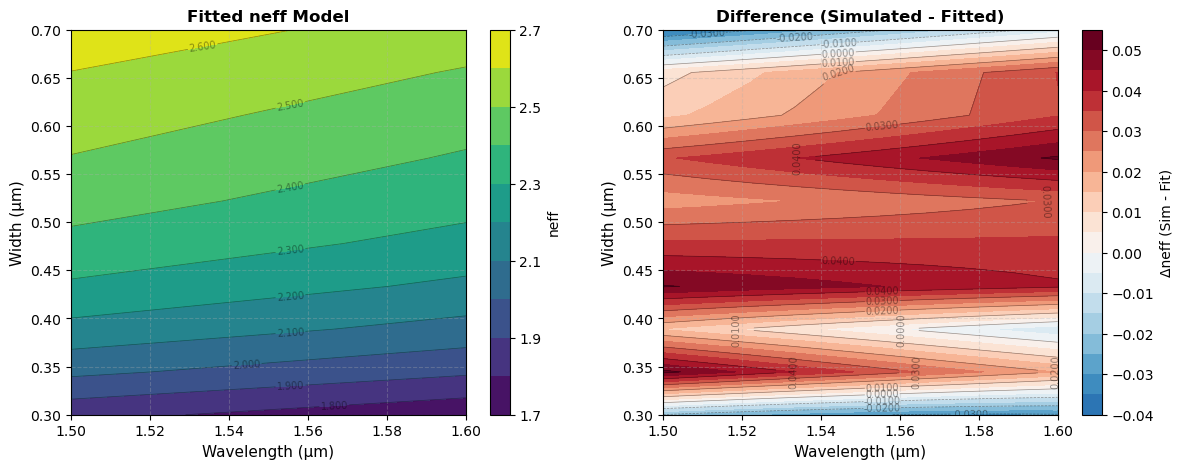

In [4]:
lam0 = 1.550
w0 = 0.50
a0 = 2.355873
a1 = 1.058993
a2 = 0.103059
b1 = 1.520782
b2 = -4.093749
b3 = -13.774248

def neff_lambda(lam):
    """Calculate neff as function of wavelength"""
    return a0 - a1*(lam - lam0) - a2*(lam - lam0)**2

def delta_neff_w(w):
    """Calculate delta neff as function of width"""
    return b1*(w - w0) + b2*(w - w0)**2 - b3*(w - w0)**3

def neff_fitted(lam, w):
    """Calculate total fitted neff"""
    return neff_lambda(lam) + delta_neff_w(w)

# Apply fitted model to all data points
df_results['neff_fitted'] = df_results.apply(
    lambda row: neff_fitted(row['wavelength'], row['width']), axis=1
)

# Calculate difference (error)
df_results['neff_difference'] = df_results['neff'] - df_results['neff_fitted']

pivot_fit = df_results.pivot(index='width', columns='wavelength', values='neff_fitted')
pivot_diff = df_results.pivot(index='width', columns='wavelength', values='neff_difference')
levels = 10
fig = plt.figure(figsize=(14,5))

ax1 = plt.subplot(1, 2, 1)
contourf2 = ax1.contourf(pivot_fit.columns, pivot_fit.index, pivot_fit.values, 
                         levels=levels, cmap='viridis')
contour2 = ax1.contour(pivot_fit.columns, pivot_fit.index, pivot_fit.values, 
                       levels=levels, colors='black', linewidths=0.5, alpha=0.4)
ax1.clabel(contour2, inline=True, fontsize=7, fmt='%.3f')
cbar2 = plt.colorbar(contourf2, ax=ax1)
cbar2.set_label('neff', fontsize=10)
ax1.set_xlabel('Wavelength (µm)', fontsize=11)
ax1.set_ylabel('Width (µm)', fontsize=11)
ax1.set_title('Fitted neff Model', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')

ax2 = plt.subplot(1, 2, 2)
# Use diverging colormap for difference
max_diff = max(abs(pivot_diff.values.min()), abs(pivot_diff.values.max()))
contourf3 = ax2.contourf(pivot_diff.columns, pivot_diff.index, pivot_diff.values, 
                         levels=20, cmap='RdBu_r', vmin=-max_diff, vmax=max_diff)
contour3 = ax2.contour(pivot_diff.columns, pivot_diff.index, pivot_diff.values, 
                       levels=10, colors='black', linewidths=0.5, alpha=0.4)
ax2.clabel(contour3, inline=True, fontsize=7, fmt='%.4f')
cbar3 = plt.colorbar(contourf3, ax=ax2)
cbar3.set_label('Δneff (Sim - Fit)', fontsize=10)
ax2.set_xlabel('Wavelength (µm)', fontsize=11)
ax2.set_ylabel('Width (µm)', fontsize=11)
ax2.set_title('Difference (Simulated - Fitted)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')

## Calculate the spectrum using TMM.

Using TMMax for the TMM calcaultions.

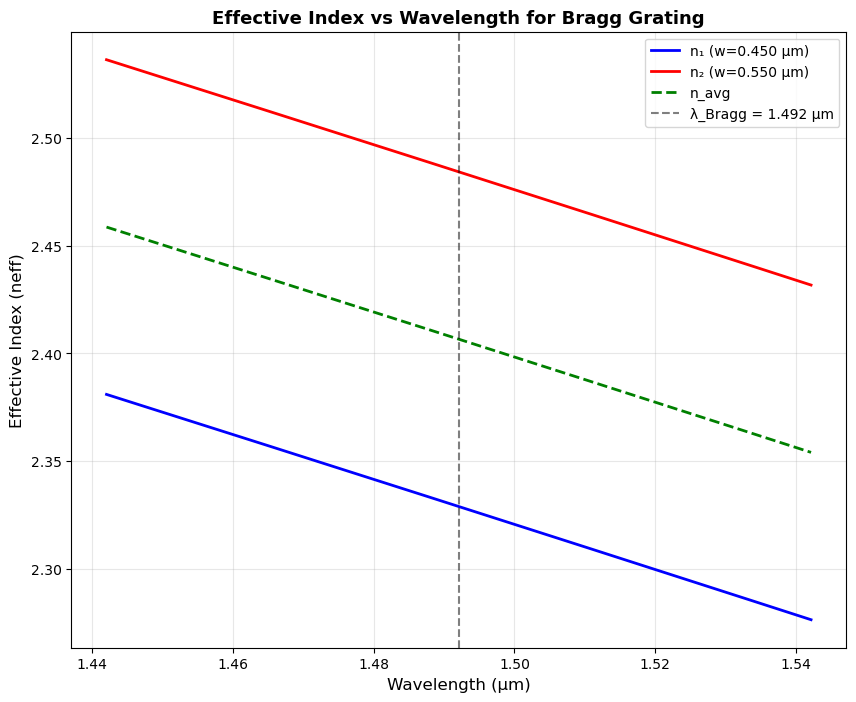

In [42]:
from scipy.optimize import fsolve
# Fit paramters 
lam0 = 1.550
w0 = 0.50
a0 = 2.355873
a1 = 1.058993
a2 = 0.103059
b1 = 1.520782
b2 = -4.093749
b3 = -13.774248

# Grating parameters 
period = 0.310 # Period of grating
NG = 50 # number of periods
L = NG*period # Grating length
width0 = 0.5 # Mean waveguide width
dwidth = 0.05 # +/- waveguide width
width1 = width0 - dwidth
width2 = width0 + dwidth

span = 0.100 
Npoints = 1000

# Calculating the index of the thick and thin regions
def neff_lambda(lam):
    """Calculate neff as function of wavelength"""
    return a0 - a1*(lam - lam0) - a2*(lam - lam0)**2

def delta_neff_w(w):
    """Calculate delta neff as function of width"""
    return b1*(w - w0) + b2*(w - w0)**2 - b3*(w - w0)**3

def bragg_equation(lam):
    """Calcaute the Bragg Wavelength"""
    neff_avg = neff_lambda(lam) + (delta_neff_w(width2)+delta_neff_w(width1))/2

    return lam - period*2*neff_avg

wavelength0 = fsolve(bragg_equation, 1.55)[0]

wavelengths = wavelength0 + np.linspace(-span/2, span/2, Npoints)

# Calculate effective indices for both widths across wavelength range
n1 = neff_lambda(wavelengths) + delta_neff_w(width1)  # neff for narrow width
n2 = neff_lambda(wavelengths) + delta_neff_w(width2)  # neff for wide width
n_avg = (n1 + n2) / 2  # Average neff

fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))

# Plot 1: Effective indices vs wavelength
ax1.plot(wavelengths, n1, 'b-', linewidth=2, label=f'n₁ (w={width1:.3f} µm)')
ax1.plot(wavelengths, n2, 'r-', linewidth=2, label=f'n₂ (w={width2:.3f} µm)')
ax1.plot(wavelengths, n_avg, 'g--', linewidth=2, label='n_avg')
ax1.axvline(wavelength0, color='black', linestyle='--', alpha=0.5, 
            label=f'λ_Bragg = {wavelength0:.3f} µm')
ax1.set_xlabel('Wavelength (µm)', fontsize=12)
ax1.set_ylabel('Effective Index (neff)', fontsize=12)
ax1.set_title('Effective Index vs Wavelength for Bragg Grating', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)



TMM code in python from the book `Silicon Photonics Design by Lukas Chrostowski and Michael Hochberg`

In [48]:
import numpy as np

def TMM_HomoWG_Matrix(wavelength, l, neff, loss):
    """
    Calculate the transfer matrix of a homogeneous waveguide.
    
    Parameters:
    -----------
    wavelength : array_like
        Wavelength array
    l : float
        Length of the waveguide
    neff : array_like
        Effective refractive index
    loss : float
        Loss parameter
    
    Returns:
    --------
    T_hw : ndarray
        Transfer matrix of shape (2, 2, len(neff))
    """
    # Complex propagation constant
    beta = 2 * np.pi * neff / wavelength - 1j * loss / 2
    
    T_hw = np.zeros((2, 2, len(neff)), dtype=complex)
    T_hw[0, 0, :] = np.exp(1j * beta * l)
    T_hw[1, 1, :] = np.exp(-1j * beta * l)
    
    return T_hw


def TMM_IndexStep_Matrix(n1, n2):
    """
    Calculate the transfer matrix for an index step from n1 to n2.
    
    Parameters:
    -----------
    n1 : array_like
        Initial refractive index
    n2 : array_like
        Final refractive index
    
    Returns:
    --------
    T_is : ndarray
        Transfer matrix of shape (2, 2, len(n1))
    """
    T_is = np.zeros((2, 2, len(n1)), dtype=complex)
    
    a = (n1 + n2) / (2 * np.sqrt(n1 * n2))
    b = (n1 - n2) / (2 * np.sqrt(n1 * n2))
    
    T_is[0, 0, :] = a
    T_is[0, 1, :] = b
    T_is[1, 0, :] = b
    T_is[1, 1, :] = a
    
    return T_is


def TMM_Grating_Matrix(wavelength, Period, NG, n1, n2, loss, phase_shift=True):
    """
    Calculate the total transfer matrix of the gratings.
    
    Parameters:
    -----------
    wavelength : array_like
        Wavelength array
    Period : float
        Grating period
    NG : int
        Number of grating periods
    n1 : array_like
        First refractive index
    n2 : array_like
        Second refractive index
    loss : float
        Loss parameter
    
    Returns:
    --------
    T : ndarray
        Total transfer matrix of shape (2, 2, len(wavelength))
    """
    l = Period / 2
    
    T_hw1 = TMM_HomoWG_Matrix(wavelength, l, n1, loss)
    T_is12 = TMM_IndexStep_Matrix(n1, n2)
    T_hw2 = TMM_HomoWG_Matrix(wavelength, l, n2, loss)
    T_is21 = TMM_IndexStep_Matrix(n2, n1)
    
    q = len(wavelength)
    Tp = np.zeros((2, 2, q), dtype=complex)
    T = np.zeros((2, 2, q), dtype=complex)
    
    for i in range(q):
        # Matrix multiplication in correct order
        Tp[:, :, i] = (T_hw2[:, :, i] @ T_is21[:, :, i] @ 
                       T_hw1[:, :, i] @ T_is12[:, :, i])
        
        # 1st order uniform Bragg grating
        T[:, :, i] = np.linalg.matrix_power(Tp[:, :, i], NG)

        # For an FP cavity, 1st order cavity, insert a high index region, n2
        if phase_shift:
            T[:, :, i] = (np.linalg.matrix_power(Tp[:, :, i], NG) @ 
                        T_hw2[:, :, i] @ 
                        np.linalg.matrix_power(Tp[:, :, i], NG) @ 
                        T_hw2[:, :, i])
    
    return T


def TMM_Grating_RT(wavelength, Period, NG, n1, n2, loss, phase_shift=True):
    """
    Calculate the R (reflectance) and T (transmittance) versus wavelength.
    
    Parameters:
    -----------
    wavelength : array_like
        Wavelength array
    Period : float
        Grating period
    NG : int
        Number of grating periods
    n1 : array_like
        First refractive index
    n2 : array_like
        Second refractive index
    loss : float
        Loss parameter
    
    Returns:
    --------
    R : ndarray
        Reflectance array
    T : ndarray
        Transmittance array
    """
    M = TMM_Grating_Matrix(wavelength, Period, NG, n1, n2, loss, phase_shift)
    
    q = len(wavelength)
    T = np.abs(np.ones(q) / M[0, 0, :])**2
    R = np.abs(M[1, 0, :] / M[0, 0, :])**2
    
    return R, T

Spectrum of Bragg grating with phase shift and no phase shift 

Text(0, 0.5, 'Response')

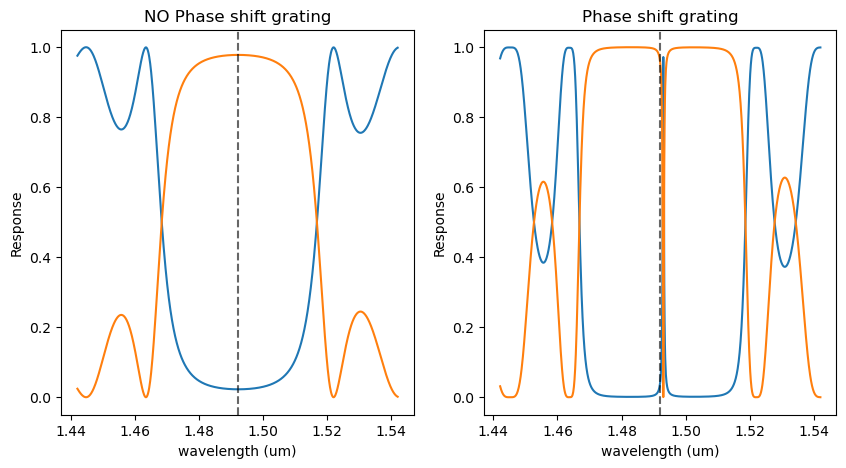

In [57]:
loss_dBcm=3 # waveguide loss, dB/cm
loss=np.log(10)*loss_dBcm/10*100
R, T = TMM_Grating_RT(wavelength=wavelengths*10**-6, Period=period*10**-6, NG=40, n1=n1, n2=n2, loss=loss, phase_shift=False)
R_shift, T_shift = TMM_Grating_RT(wavelength=wavelengths*10**-6, Period=period*10**-6, NG=40, n1=n1, n2=n2, loss=loss, phase_shift=True)

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.plot(wavelengths, T)
ax1.plot(wavelengths,R)
ax1.axvline(wavelength0, color='black', linestyle='--',alpha=0.6)
ax1.set_title('NO Phase shift grating')
ax1.set_xlabel('wavelength (um)')
ax1.set_ylabel('Response')

ax2 = plt.subplot(1,2,2)
ax2.plot(wavelengths,T_shift)
ax2.plot(wavelengths,R_shift)
ax2.axvline(wavelength0, color='black', linestyle='--',alpha=0.6)
ax2.set_title('Phase shift grating')
ax2.set_xlabel('wavelength (um)')
ax2.set_ylabel('Response')

## Model using MEEP

In [27]:
%%writefile dbr_MPI_sim.py
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs

mp.verbosity(0)

wg_width = 0.5
delta_width=0.050
period = 0.310
length = period/2
NG=40
dbr = gf.components.dbr(
    w1=wg_width+delta_width,
    w2=wg_width-delta_width,
    l1=length,
    l2=length,
    n=40,
    straight_length=1).copy()
dbr.add_port(name='o2', center=(dbr.xmax, 0), width=wg_width, orientation=0,layer=(1,0))

# Set up frequency points for simulation
npoints = 10000
lcen = 1.492
dlam = 0.100
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl

# Center frequency mode_parity
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 80

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

# Cell size
cell_size = mp.Vector3(dbr.xsize + 2 * dpml, dbr.ysize + 2 * dpml + 2 * dpad, 0)

# Create the ring resonator component
dbr = gf.components.extend_ports(dbr, port_names=["o1", "o2"], length=2)
dbr = dbr.copy()
dbr.flatten()
dbr.center = (0, 0)

# Get geometry from component
geometry = gm.get_meep_geometry.get_meep_geometry_from_component(dbr)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]
# Source
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint=mp.Vector3(1, 0, 0),
        direction=mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(dbr.ports["o1"].x + dpml + 2, dbr.ports["o1"].y),
        amplitude=1
    ),
]

# Simulation
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(dpml)],
    sources=source,
    geometry=geometry,
    default_material=SiO2,
    # symmetries=[mp.Mirror(mp.Y)]
)

# Mode monitors
m1 = mp.Volume(
    center=mp.Vector3(dbr.ports["o1"].x + dpml + 2 + 0.5, dbr.ports["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(dbr.ports["o2"].x - dpml - 1 - 0.5, dbr.ports["o2"].y),
    size=mp.Vector3(0, 1),
)

mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
whole_dft = sim.add_dft_fields([mp.Ez], 0.6489713803621261, 0, 1, center=mp.Vector3(), size=cell_size)

# Only plot from master process
if mp.am_master():
    print(f"Running simulation with {mp.count_processors()} MPI processes...")
    sim.plot2D(labels=False)
    plt.savefig('simulation_geometry.png', dpi=150, bbox_inches='tight')
    plt.close()

# Run simulation
# sim.run(
#         until_after_sources=mp.stop_when_fields_decayed(
#             25, mp.Ez, 1e-2
#         )
#     )
sim.run(
    mp.at_every(2000, lambda sim: print(f"Time: {sim.meep_time():.1f}")),
    until_after_sources=mp.stop_when_dft_decayed(tol=1e-9, maximum_run_time=10000)
)

# Calculate S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_1, [1], eig_parity=mode_parity
).alpha[0, :, 0]

port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[0, :, 1]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[0, :, 0]
    / norm_mode_coeff
)

# Get field data
eps_data = sim.get_epsilon()
ez_data = sim.get_dft_array(whole_dft, mp.Ez, 0)

# Save results (only from master process)
if mp.am_master():
    np.save('dbr_wavelengths.npy', wl)
    np.save('dbr_port1_coeff.npy', port1_coeff)
    np.save('dbr_port2_coeff.npy', port2_coeff)
    np.save('dbr_eps_data.npy', eps_data)
    np.save('dbr_ez_data.npy', ez_data)
    
    # Create field plot
    fig = plt.figure(figsize=(12, 8))
    ax_field = fig.add_subplot(1, 1, 1)
    ax_field.set_title("Steady State Fields")
    ax_field.imshow(
        np.flipud(np.transpose(eps_data)),
        interpolation="spline36",
        cmap="binary"
    )

    ax_field.imshow(
        np.flipud(np.transpose(np.real(ez_data))),
        interpolation="spline36",
        cmap="RdBu",
        alpha=0.9,
    )
    ax_field.axis("off")
    plt.savefig('dbr_steady_state_fields.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    print("Simulation completed successfully!")
    print(f"Results saved to: wavelengths.npy, port1_coeff.npy, port2_coeff.npy, eps_data.npy, ez_data.npy")
    print(f"Plots saved to: simulation_geometry.png, steady_state_fields.png")



Overwriting dbr_MPI_sim.py


In [28]:
!mpirun -np 24 python dbr_MPI_sim.py

/bin/bash: /home/ramprakash/anaconda3/envs/QE/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Using MPI version 4.1, 24 processes
2025-10-14 18:43:06.283 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']
Running simulation with 24 MPI processes...
Simulation completed successfully!
Results saved to: wavelengths.npy, port1_coeff.npy, port2_coeff.npy, eps_data.npy, ez_data.npy
Plots saved to: simulation_geometry.png, steady_state_fields.png

Elapsed run time = 114.5774 s


For refelction 2 simulations are required to subtract the incident field. This requires two simulations with and the without the structure. This is not done here to save time.

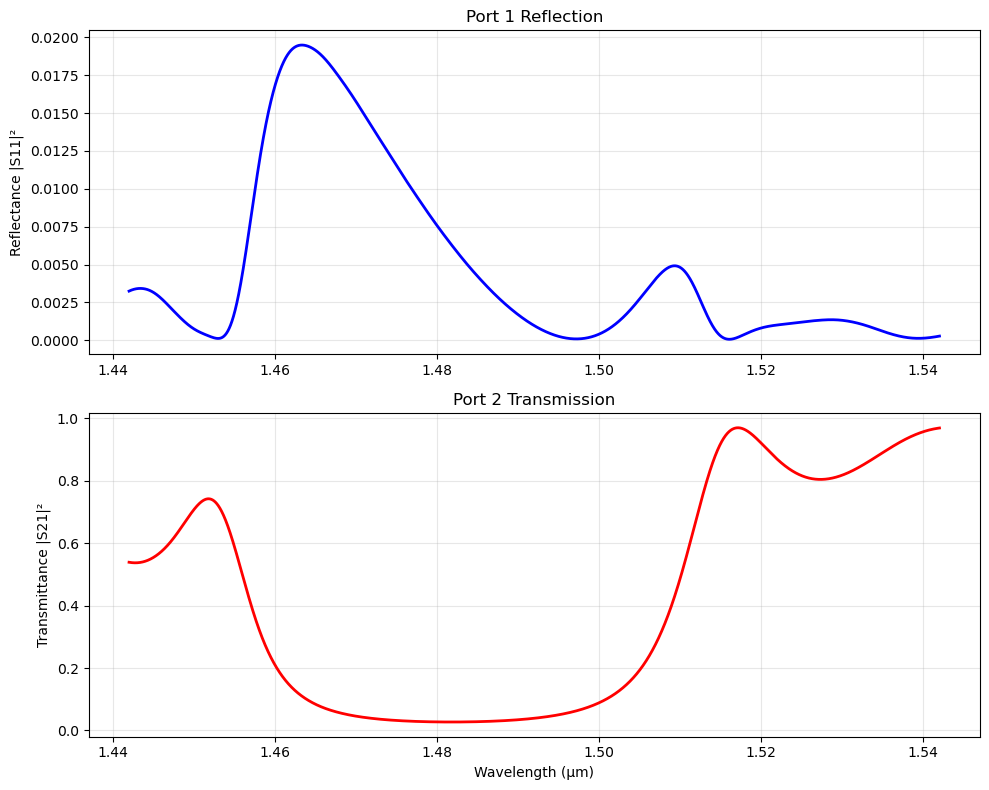

Peak transmission: 0.0271
Resonance wavelength: 1.4817 μm


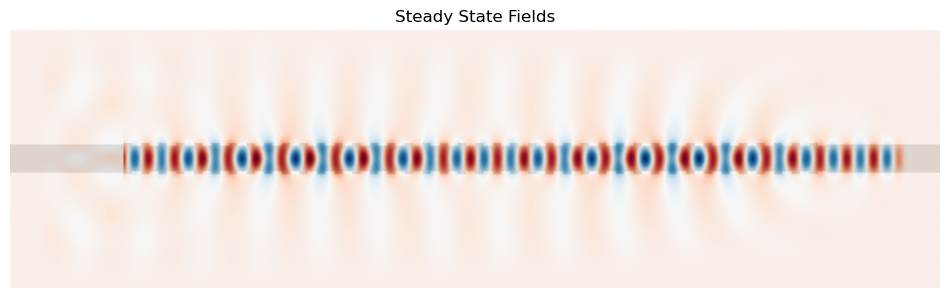

In [29]:

# Load results
wl = np.load('dbr_wavelengths.npy')
port1_coeff = np.load('dbr_port1_coeff.npy')
port2_coeff = np.load('dbr_port2_coeff.npy')
eps_data = np.load('dbr_eps_data.npy')
ez_data = np.load('dbr_ez_data.npy')

# Plot transmission spectrum
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# S11 (reflection)
ax1.plot(wl, (np.abs(port1_coeff)**2), 'b-', linewidth=2)
ax1.set_ylabel('Reflectance |S11|²')
ax1.set_title('Port 1 Reflection')
ax1.grid(True, alpha=0.3)

# S21 (transmission)
ax2.plot(wl, (np.abs(port2_coeff)**2), 'r-', linewidth=2)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Transmittance |S21|²')
ax2.set_title('Port 2 Transmission')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('transmission_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Peak transmission: {np.min(np.abs(port2_coeff)**2):.4f}")
print(f"Resonance wavelength: {wl[np.argmin(np.abs(port2_coeff)**2)]:.4f} μm")

fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields")
ax_field.imshow(
     np.flipud(np.transpose(eps_data)),
      interpolation="spline36",
      cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()

## Phase shift DBR

Meep Modeling

In [21]:
%%writefile pi_dbr_MPI_sim.py
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs

mp.verbosity(0)

wg_width = 0.5
delta_width=0.050
period = 0.310
length = period/2
NG=40
@gf.cell
def phase_shift_dbr(period = 0.310, n_period = 40, width1 = 0.55, width2 = 0.45):
    # Create the two-segment unit cell of the DBR
    length=period/2
    dbr1 = gf.components.dbr(w1=width2,w2=width1,l1=length,l2=length,n=n_period/2,straight_length=0).copy()
    dbr1.add_port(name='o2', center=(dbr1.xmax, 0), width=width1, orientation=0,layer=(1,0))
    dbr2 = gf.components.dbr(w1=width1,w2=width2,l1=length,l2=length,n=n_period/2,straight_length=0).copy()
    dbr2.add_port(name='o2', center=(dbr2.xmax, 0), width=width1, orientation=0,layer=(1,0))
    straight = gf.components.straight(length=3, width=0.5)

    phase_dbr = gf.Component()
    dbr1_ref = phase_dbr.add_ref(dbr1)
    dbr2_ref = phase_dbr.add_ref(dbr2)
    straight1_ref = phase_dbr.add_ref(straight)
    straight2_ref = phase_dbr.add_ref(straight)
    dbr1_ref.connect("o2", dbr2_ref.ports["o1"], allow_width_mismatch=True) 
    straight1_ref.connect("o1", dbr2_ref.ports["o2"], allow_width_mismatch=True)
    straight2_ref.connect("o2", dbr1_ref.ports["o1"], allow_width_mismatch=True)

    return phase_dbr   

gf.clear_cache()
pi_dbr = phase_shift_dbr().copy()
pi_dbr.add_port(name='o2', center=(pi_dbr.xmax, 0), width=0.5, orientation=0,layer=(1,0))
pi_dbr.add_port(name='o1', center=(pi_dbr.xmin, 0), width=0.5, orientation=180,layer=(1,0))

# Set up frequency points for simulation
npoints = 10000
lcen = 1.492
dlam = 0.100
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl

# Center frequency mode_parity
mode_parity = mp.EVEN_Y + mp.ODD_Z
dpml = 1
dpad = 1
resolution = 80

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

# Cell size
cell_size = mp.Vector3(pi_dbr.xsize + 2 * dpml, pi_dbr.ysize + 2 * dpml + 2 * dpad, 0)

# Create the ring resonator component
pi_dbr = gf.components.extend_ports(pi_dbr, port_names=["o1", "o2"], length=2)
pi_dbr = pi_dbr.copy()
pi_dbr.flatten()
pi_dbr.center = (0, 0)

# Get geometry from component
geometry = gm.get_meep_geometry.get_meep_geometry_from_component(pi_dbr)

geometry = [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in geometry
]
# Source
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src=src,
        eig_band=1,
        eig_parity=mode_parity,
        eig_kpoint=mp.Vector3(1, 0, 0),
        direction=mp.NO_DIRECTION,
        size=mp.Vector3(0, 1),
        center=mp.Vector3(pi_dbr.ports["o1"].x + dpml + 2, pi_dbr.ports["o1"].y),
        amplitude=1
    ),
]

# Simulation
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.PML(dpml)],
    sources=source,
    geometry=geometry,
    default_material=SiO2,
    # symmetries=[mp.Mirror(mp.Y)]
)

# Mode monitors
m1 = mp.Volume(
    center=mp.Vector3(pi_dbr.ports["o1"].x + dpml + 2 + 0.5, pi_dbr.ports["o1"].y),
    size=mp.Vector3(0, 1),
)
m2 = mp.Volume(
    center=mp.Vector3(pi_dbr.ports["o2"].x - dpml - 1 - 0.5, pi_dbr.ports["o2"].y),
    size=mp.Vector3(0, 1),
)

mode_monitor_1 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m1))
mode_monitor_2 = sim.add_mode_monitor(fpoints, mp.ModeRegion(volume=m2))
whole_dft = sim.add_dft_fields([mp.Ez], 0.6489713803621261, 0, 1, center=mp.Vector3(), size=cell_size)

# Only plot from master process
if mp.am_master():
    print(f"Running simulation with {mp.count_processors()} MPI processes...")
    sim.plot2D(labels=False)
    plt.savefig('simulation_geometry.png', dpi=150, bbox_inches='tight')
    plt.close()

# Run simulation
# sim.run(
#         until_after_sources=mp.stop_when_fields_decayed(
#             25, mp.Ez, 1e-2
#         )
#     )
sim.run(
    mp.at_every(2000, lambda sim: print(f"Time: {sim.meep_time():.1f}")),
    until_after_sources=mp.stop_when_dft_decayed(tol=1e-9, maximum_run_time=10000)
)

# Calculate S parameters
norm_mode_coeff = sim.get_eigenmode_coefficients(
    mode_monitor_1, [1], eig_parity=mode_parity
).alpha[0, :, 0]

port1_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_1, [1], eig_parity=mode_parity).alpha[0, :, 1]
    / norm_mode_coeff
)

port2_coeff = (
    sim.get_eigenmode_coefficients(mode_monitor_2, [1], eig_parity=mode_parity).alpha[0, :, 0]
    / norm_mode_coeff
)

# Get field data
eps_data = sim.get_epsilon()
ez_data = sim.get_dft_array(whole_dft, mp.Ez, 0)

# Save results (only from master process)
if mp.am_master():
    np.save('pi_dbr_wavelengths.npy', wl)
    np.save('pi_dbr_port1_coeff.npy', port1_coeff)
    np.save('pi_dbr_port2_coeff.npy', port2_coeff)
    np.save('pi_dbr_eps_data.npy', eps_data)
    np.save('pi_dbr_ez_data.npy', ez_data)
    
    # Create field plot
    fig = plt.figure(figsize=(12, 8))
    ax_field = fig.add_subplot(1, 1, 1)
    ax_field.set_title("Steady State Fields")
    ax_field.imshow(
        np.flipud(np.transpose(eps_data)),
        interpolation="spline36",
        cmap="binary"
    )

    ax_field.imshow(
        np.flipud(np.transpose(np.real(ez_data))),
        interpolation="spline36",
        cmap="RdBu",
        alpha=0.9,
    )
    ax_field.axis("off")
    plt.savefig('pi_dbr_steady_state_fields.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    print("Simulation completed successfully!")
    print(f"Results saved to: wavelengths.npy, port1_coeff.npy, port2_coeff.npy, eps_data.npy, ez_data.npy")
    print(f"Plots saved to: simulation_geometry.png, steady_state_fields.png")

Overwriting pi_dbr_MPI_sim.py


In [22]:
!mpirun -np 24 python pi_dbr_MPI_sim.py

/bin/bash: /home/ramprakash/anaconda3/envs/QE/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Using MPI version 4.1, 24 processes
2025-10-14 18:34:23.919 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']
Running simulation with 24 MPI processes...
Simulation completed successfully!
Results saved to: wavelengths.npy, port1_coeff.npy, port2_coeff.npy, eps_data.npy, ez_data.npy
Plots saved to: simulation_geometry.png, steady_state_fields.png

Elapsed run time = 147.2282 s


For refelction 2 simulations are required to subtract the incident field. This requires two simulations with and the without the structure. This is not done here to save time

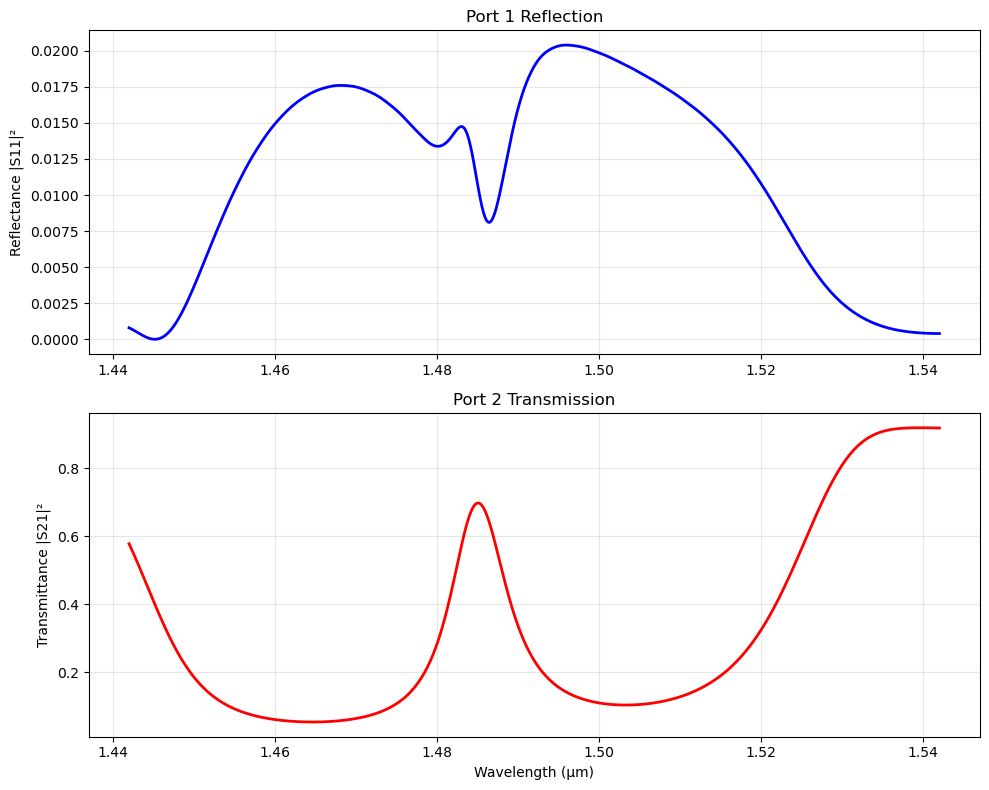

Peak transmission: 0.0545
Resonance wavelength: 1.4646 μm


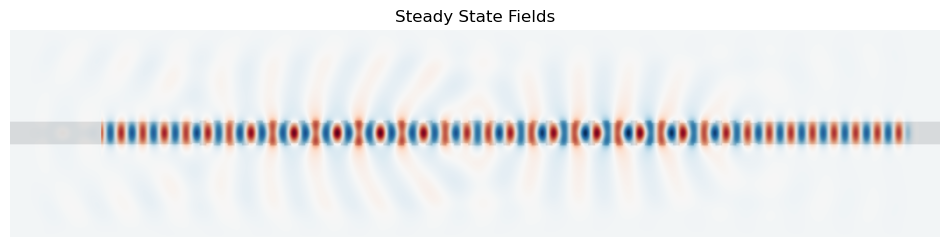

In [25]:

# Load results
wl = np.load('pi_dbr_wavelengths.npy')
port1_coeff = np.load('pi_dbr_port1_coeff.npy')
port2_coeff = np.load('pi_dbr_port2_coeff.npy')
eps_data = np.load('pi_dbr_eps_data.npy')
ez_data = np.load('pi_dbr_ez_data.npy')

# Plot transmission spectrum
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# S11 (reflection)
ax1.plot(wl, (np.abs(port1_coeff)**2), 'b-', linewidth=2)
ax1.set_ylabel('Reflectance |S11|²')
ax1.set_title('Port 1 Reflection')
ax1.grid(True, alpha=0.3)

# S21 (transmission)
ax2.plot(wl, (np.abs(port2_coeff)**2), 'r-', linewidth=2)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Transmittance |S21|²')
ax2.set_title('Port 2 Transmission')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('transmission_spectrum.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Peak transmission: {np.min(np.abs(port2_coeff)**2):.4f}")
print(f"Resonance wavelength: {wl[np.argmin(np.abs(port2_coeff)**2)]:.4f} μm")

fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields")
ax_field.imshow(
     np.flipud(np.transpose(eps_data)),
      interpolation="spline36",
      cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()